In [1]:
import simba as si
import numpy as np
import pandas as pd
import scanpy as sc
import scprep, phate
import matplotlib.pyplot as plt
import leidenalg
from scipy.spatial.distance import cdist

2024-06-24 14:07:33.513913: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 14:07:33.515717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 14:07:33.555473: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 14:07:33.556697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 14:07:34.355886: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [6]:
dataset = 'tcells'

In [7]:
adata = sc.read_h5ad('/home/av622/palmer_scratch/all_cd8_t_cells.h5ad')

In [8]:
data, data_hvgs = scprep.select.highly_variable_genes(adata.to_df(), adata.var_names, percentile=90)
data_hvg = data[data_hvgs]
data_hvg = data_hvg / np.linalg.norm(data_hvg, axis=0)

In [9]:
uniform_signal = np.ones((1, data_hvg.shape[0]))
uniform_signal = (uniform_signal / np.linalg.norm(uniform_signal, axis=1)).reshape(-1,1)
data = np.hstack((data_hvg, uniform_signal))
adata_hvg = sc.AnnData(data)

/tmp/ipykernel_2949040/3841727164.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_hvg = sc.AnnData(data)


In [10]:
adata_hvg.obs_names = adata.obs_names
adata_hvg.var_names = list(data_hvgs) + ['uniform']

In [11]:
adata = adata_hvg

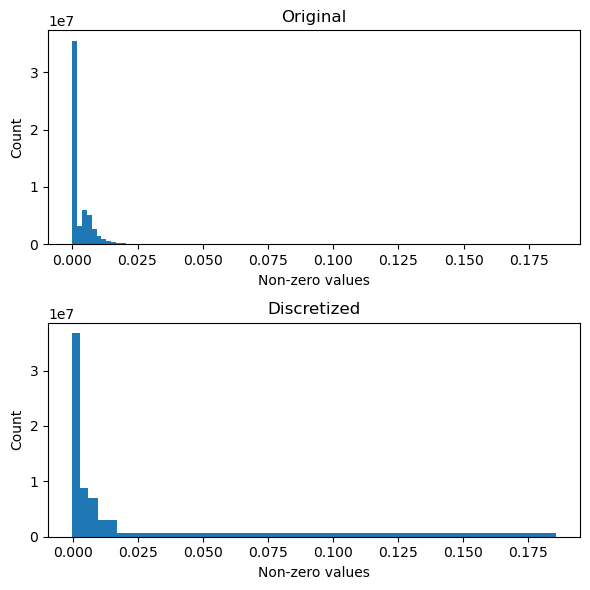

In [12]:
si.tl.discretize(adata)
si.pl.discretize(adata)

In [14]:
si.tl.gen_graph(list_CG=[adata],
                layer='simba',
                use_highly_variable=False,
                dirname=f'simba_graph_{dataset}_final_run')

relation0: source: C, destination: G
#edges: 28130284
relation1: source: C, destination: G
#edges: 18580485
relation2: source: C, destination: G
#edges: 4538316
relation3: source: C, destination: G
#edges: 3289259
relation4: source: C, destination: G
#edges: 1418860
relation5: source: C, destination: G
#edges: 303364
Total number of edges: 56260568
Writing graph file "pbg_graph.txt" to "/home/av622/palmer_scratch/pbg/simba_graph_tcells_final_run" ...
Finished.


In [15]:
dict_config = si.settings.pbg_params.copy()
dict_config['dimension'] = 128 # comparable to other methods

In [16]:
si.tl.pbg_train(pbg_params = dict_config, auto_wd=True, save_wd=True, output=f'model_128_{dataset}_final_run')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.00042
Weight decay being used for training is 0.00042
Converting input data ...
[2024-05-23 10:58:23.283845] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2024-05-23 10:58:23.284355] These files are in: /home/av622/palmer_scratch/pbg/simba_graph_tcells_final_run/input/entity, /home/av622/palmer_scratch/pbg/simba_graph_tcells_final_run/input/edge
Starting training ...


/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/torchbiggraph/util.py:211: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_type = dummy_tensor.storage_type()
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/torch/storage.py:959: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if self.device.type not in ['cpu', 'cuda']:
/gpfs/gibbs/project/krishnaswamy_smita/av622/conda_envs/gspa/lib/python3.8/site-packages/torch/storage.py:962: U

Finished


## Get gene clusters, localization, and reformat

In [20]:
dataset = 'tcells'
path = f'/home/av622/palmer_scratch/pbg/simba_graph_{dataset}_final_run/'
run = f'model_128_{dataset}_final_run'
path_emb = path + run
path_entity = path + '/input/entity'

adata_G = si.read_embedding(path_emb=path_emb, path_entity=path_entity)['G']

In [52]:
df_results = adata_G.to_df().loc[data_hvgs]
uniform = adata_G.to_df().loc['uniform']

In [56]:
gene_phate_op = phate.PHATE()
gene_phate = gene_phate_op.fit_transform(df_results)

Calculating PHATE...
  Running PHATE on 1416 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.11 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.18 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.31 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 0.75 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.35 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.21 seconds.
Calculated PHATE in 3.62 seconds.


In [57]:
gene_clusters = np.array(leidenalg.find_partition(gene_phate_op.graph.to_igraph(), 
                                                  leidenalg.ModularityVertexPartition,
                                                  seed=0).membership)
gene_clusters = pd.Series(gene_clusters, index=data_hvgs.values)

In [58]:
localization_score = cdist(uniform.values, df_results.values).reshape(-1,)

In [60]:
np.savez('./results/SIMBA_gene_embedding.npz', 
         signal_embedding=df_results.values,
         localization_score=localization_score,
         genes=data_hvgs.values, clusters=gene_clusters.values)